## Supervised Multi AI Agent Architecture

In [131]:
from langchain_groq import ChatGroq
from langgraph.graph import START,END,StateGraph
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langchain_core.messages import SystemMessage,HumanMessage,AIMessage
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import add_messages
from dotenv import load_dotenv
from typing import TypedDict,Annotated,Dict

load_dotenv()

llm=ChatGroq(model='llama-3.1-8b-instant')
checkptr=InMemorySaver()
config={"configurable":{"thread_id":"1"}}

In [132]:
class schema(TypedDict):
    """State for the multi-agent system"""
    messages:Annotated[list,add_messages]
    next_agent: str = ""
    research_data: str = ""
    analysis: str = ""
    final_report: str = ""
    task_complete: bool = False
    current_task: str = ""

In [133]:
def supervisor(state:schema)->schema:
    """Supervisor node to decide which node the data should go to next"""
    task = state["messages"][-1].content if state["messages"] else "No task"
    print("Task is: ",task)
    
    has_research = bool(state.get("research_data", ""))
    has_analysis = bool(state.get("analysis", ""))
    has_report = bool(state.get("final_report", ""))
    
    sysmsg = SystemMessage(content=f"""You are a smart Supervisor working with a team of agents:
1. Researcher - Gathers information and data
2. Analyst - Analyzes data and provides insights
3. Writer - Creates reports and summaries

Based on the current state and conversation, decide which agent should work next.
If the task is complete, respond with 'DONE'.

Current state:
- Has research data: {has_research}
- Has analysis: {has_analysis}
- Has report: {has_report}

Task: {task}

Respond with ONLY the agent name (researcher/analyst/writer) or 'DONE'.""")
    
    decision = llm.invoke([sysmsg])
    decision_text = decision.content.strip().lower()

    print(decision_text)
    if "done" in decision_text or has_report:
        next_agent = "end"
        supervisor_msg = "Supervisor: All tasks done"
    elif "researcher" in decision_text or not has_research:
        next_agent = "researcher"
        supervisor_msg = "Assigning to Researcher..."
    elif "analyst" in decision_text or (has_research and not has_analysis):
        next_agent = "analyst"
        supervisor_msg = "Assigning to Analyst..."
    elif "writer" in decision_text or (has_analysis and not has_report):
        next_agent = "writer"
        supervisor_msg = "Assigning to Writer..."
    else:
        next_agent = "end"
        supervisor_msg = "Task seems complete."
    
    return {
        "messages": [AIMessage(content=supervisor_msg)],
        "next_agent": next_agent,
        "current_task": task
    }

In [134]:
def researcher_agent(state:schema)->schema:
    task=state.get("current_task")
    research_prompt = f"""As a research specialist, provide comprehensive information about: {task}

    Include:
    1. Key facts and background
    2. Current trends or developments
    3. Important statistics or data points
    4. Notable examples or case studies
    
    Be concise but thorough."""
    research_res=llm.invoke([research_prompt])
    data=research_res.content
     # Create agent message
    agent_message = f" Researcher: I've completed the research on {task}.\n Findings: {data}"
    
    
    return {
        "messages": [AIMessage(content=agent_message)],
        "research_data": data,
        "next_agent": "supervisor"
    }

In [135]:

def analyst_agent(state:schema) ->schema:
    research_data = state.get("research_data", "")
    task = state.get("current_task", "")
    
    # Create analysis prompt
    analysis_prompt = f"""As a data analyst, analyze this research data and provide insights:

Research Data:
{research_data}

Provide:
1. Key insights and patterns
2. Strategic implications
3. Risks and opportunities
4. Recommendations

Focus on actionable insights related to: {task}"""
    
    # Get analysis from LLM
    analysis_response = llm.invoke([analysis_prompt])
    analysis = analysis_response.content
    
    # Create agent message
    agent_message = f" analysis.\n\nTop insights:\n{analysis}..."
    
    return {
        "messages": [AIMessage(content=agent_message)],
        "analysis": analysis,
        "next_agent": "supervisor"
    }

In [136]:
def writer_agent(state: schema) ->schema:
    research_data = state.get("research_data", "")
    analysis = state.get("analysis", "")
    task = state.get("current_task", "")
    
    # Create writing prompt
    writing_prompt = f"""As a professional writer, create an executive report based on:

            Task: {task}

            Research Findings:
            {research_data}

            Analysis:
            {analysis}

            Create a well-structured report with:
            1. Executive Summary
            2. Key Findings  
            3. Analysis & Insights
            4. Recommendations
            5. Conclusion

            Keep it professional and concise."""
    
               
    report_response = llm.invoke([writing_prompt])
    report = report_response.content
    final_report = f"""
    {report}

    {'='*50}
    Report compiled by Multi-Agent AI System powered by Groq
    """
    
    return {
        "messages": [AIMessage(content=f" Writer: Report complete! See below for the full document.")],
        "final_report": final_report,
        "next_agent": "supervisor",
        "task_complete": True
    }

In [137]:
def where_to_go(state:schema)->str:
    next_agent=state.get("next_agent","supervisor")
    if(next_agent=="end" or state.get("task_complete",False)):
        return END
    if next_agent in ['researcher','supervisor','writer','analyst']:
        return next_agent
    return "supervisor"

In [138]:
graph=StateGraph(schema)
graph.add_node("supervisor",supervisor)
graph.add_node("researcher",researcher_agent)
graph.add_node("analyst",analyst_agent)
graph.add_node("writer",writer_agent)

graph.set_entry_point("supervisor")
graph.add_conditional_edges(
        "supervisor",
        where_to_go,
        {
            "supervisor": "supervisor",
            "researcher": "researcher",
            "analyst": "analyst",
            "writer": "writer",
            END: END
        }
    )
for node in ['researcher','analyst','writer']:
    graph.add_edge(node,"supervisor")

app=graph.compile(checkpointer=checkptr)



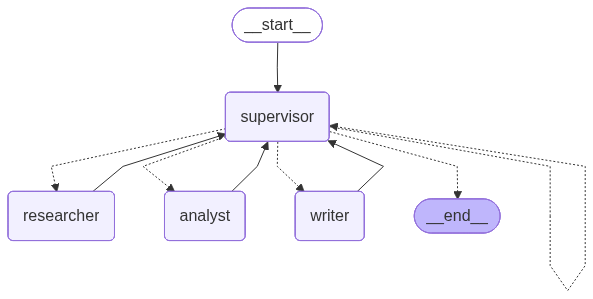

In [139]:
from IPython.display import Image,display
display(Image(app.get_graph().draw_mermaid_png()))

In [140]:
userinp=input("Enter your Query(exit to quit): ")
 
res=app.stream({"messages":[userinp]},config=config)
for step in res:
    print("Steps: ",step)
    for node_name, state in step.items():
        print(f"\n{'='*50}\n{node_name.upper()}\n{'='*50}")
        if "messages" in state and state["messages"]:
            state["messages"][-1].pretty_print()
        if node_name == "writer" and "final_report" in state:
            print("\n📄 FINAL REPORT:\n")
            print(state["final_report"])

Task is:  Tell me about gold rates in India in brief
researcher
Steps:  {'supervisor': {'messages': [AIMessage(content='Assigning to Researcher...', additional_kwargs={}, response_metadata={}, id='796e74dd-ee9e-429c-a9e5-835ecdc4571e')], 'next_agent': 'researcher', 'current_task': 'Tell me about gold rates in India in brief'}}

SUPERVISOR
================================== Ai Message ==================================

Assigning to Researcher...
Steps:  {'researcher': {'messages': [AIMessage(content=" Researcher: I've completed the research on Tell me about gold rates in India in brief.\n Findings: **Gold Rates in India: A Comprehensive Overview**\n\n**1. Key Facts and Background**\n\n* Gold is a highly valued metal in Indian culture, often used for jewelry, decorations, and investments.\n* The Indian gold market is one of the largest in the world, with a significant portion of gold demand coming from the country's vast jewelry industry.\n* The Indian government has implemented policie